<span style="font-size:5em;">Neural network from scratch</span>

**Michał M.**

In this notebook I implement basic neural network using numpy and pandas. I do not use any well known frameworks as Tensorflow or Pytorch, it is just an exercise. I will publish it on Kaggle as a notebook for educational purposes.

The idea of this notebook is based on Jan Chorowski Neural Networks class conducted at Institute of Computer Science, University of Wrocław.

I will write the code first and then I would add some theory.

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sopt
from sklearn import datasets

# Gradient descent and other optimization approaches

The Gradient Descent algorithm finds the minimum of a given function by taking small steps along the function's gradient. In pseudocode:

>$\Theta \leftarrow \Theta_0$
>
>**while** stop condition not met **do**
>
>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$
>
>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$ denotes $f$'s gradient at $\Theta$ and $\alpha$ is the step size, taking typically values from $10^{-4},\ldots,10^{-1}$.

In [121]:
# Rosenbrock function

def rosenbrock_v(x, a=1, b=100):
    """  
    Returns the value of Rosenbrock's function.
    
    Parameters
    ----------
    x : arguments as an array of length 2
    
    a, b : parameters of Rosenbrock's function
            
    Returns
    ----------
    foo : float, value of Rosenbrock's function at x
    """
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

def rosenbrock(x):
    """
    Returns the value of Rosenbrock's function and its gradient.
    
    Parameters
    ----------
    x : arguments as an array of length 2
                
    Returns
    ----------
    foo : ndarray of shape (2,)
        - value : value of Rosenbrock's function
        - gradient : ndarray of shape (2,) containing gradient values 
    """
    a = 1
    b = 100
    value  = rosenbrock_v(x)
    dVdx0 = -2*(a - x[0]) - 2*b*(x[1]-x[0]**2) * 2*x[0]
    dVdx1 = 2*b * (x[1]-x[0]**2)
    gradient = np.array([dVdx0, dVdx1])    
    return np.array([value, gradient])

In [122]:
# Gradient descent algorithm

def GD(f, x_zero, alpha=2e-3, stop_tolerance=1e-10, max_steps=1e6, verbose=False):
    """    
    Runs gradient descent algorithm on f.
    
    The basic iteration is:
    val, dVdX <- f(X)
    Theta <- -alpha * dVdX
    
    Parameters
    ----------
    f : function to optimize, should return array with [value, gradient]

        
    x_zero : starting point
        
    alpha : step length
    
    stop_tolerance : stop iterations when improvement is below this threhsold
        
    max_steps : maximum number of steps
    
    verbose : should additional info be printed?
    
    Returns
    ----------
    Theta, history : tuple
        - X : argument for which f attain optimum
        - history : list of length num_steps containing tuples (Theta, (val, dValdX))
    """
    history = []
    
    x = x_zero
    value = np.inf
    
    step = 0
    while step < max_steps:
        previous_value = value
        value, gradient = f(x)
        history.append([x, (value, gradient)])
        
        if np.abs(previous_value-value) < stop_tolerance:
            break
        
        x = x - alpha*gradient
        
        step += 1
    
    history.append([x, f(x)])
    
    if verbose:
        print ("Found optimum at %s in %d steps." % (x, len(history)))
    
    return x, history

In [123]:
initial_x = [-0.45, 2.25]
Xopt, Xhist = GD(rosenbrock, initial_x, alpha=2e-3, verbose=True)

values_hist = [t[1][0] for t in Xhist]


x = np.arange(-2.25,2.25,0.01)
y = np.arange(-1,2.5,0.01)
X,Y = np.meshgrid(x,y)
Z = rosenbrock_v([X, Y])

Found optimum at [0.99975021 0.99949949] in 9243 steps.


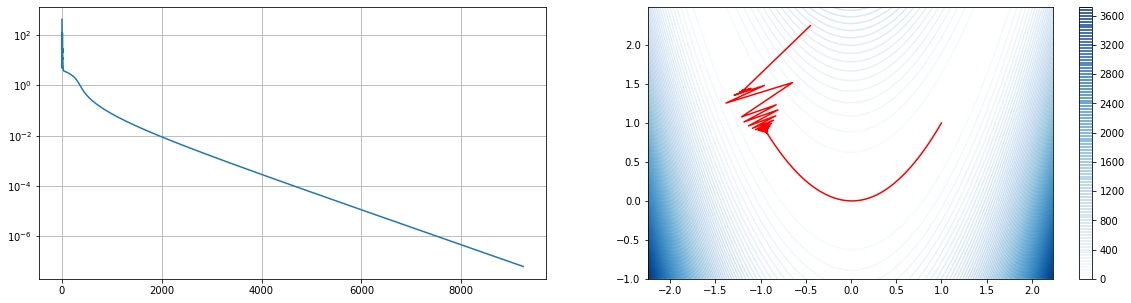

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].grid()
axes[0].set_yscale("log")
axes[0].plot(values_hist)

axes[1].plot([t[0][0] for t in Xhist], [t[0][1] for t in Xhist], color='red')
im = axes[1].contour(X, Y, Z, 100, cmap='Blues')
fig.colorbar(im, ax=axes[1])

plt.show()

In [125]:
# SciPy BFGS algorithm
    
def fmin_l_bfgs_b_hist(f, x_zero, max_steps=15000, verbose=False):
    """
    Wrapper for fmin_l_bfgs_b function from scipy library. 
    Returns the optimal value of the underlying function and history of an optimization.
    
    Parameters
    ----------
    f : function to optimize
        
    x_zero : starting point
        
    max_steps : maximum number of steps
    
    verbose : should additional info be printed?
    
    Returns
    ----------
    Theta, history : tuple
        - X : argument for which f attain optimum
        - history : list of length num_steps containing tuples (X, (val, dValdX))
    """
    history = []
    history.append([x_zero, tuple(f(x_zero))])

    x_optimal = sopt.fmin_l_bfgs_b(f, x_zero, maxiter=max_steps, callback=lambda x: history.append([x, tuple(f(x))]))[0]
    
    if verbose:
        print ("Found optimum at %s in %d steps." % (x_optimal, len(history)))
    
    return x_optimal, history

In [126]:
Xopt_bfgs, Xhist_bfgs = fmin_l_bfgs_b_hist(rosenbrock, initial_x, verbose=True)

values_hist_bfgs = [t[1][0] for t in Xhist_bfgs]

Found optimum at [0.99999992 0.99999983] in 38 steps.


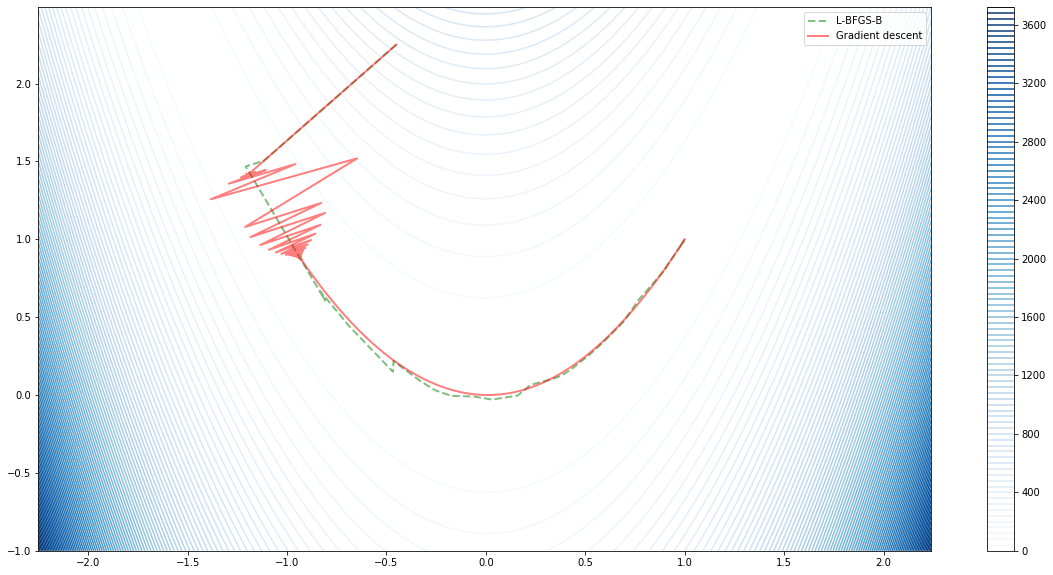

In [127]:
plt.subplots(figsize=(20, 10))

plt.plot([t[0][0] for t in Xhist_bfgs], [t[0][1] for t in Xhist_bfgs], '--', color='green', alpha=0.5, linewidth=2, label='L-BFGS-B')
plt.plot([t[0][0] for t in Xhist], [t[0][1] for t in Xhist], color='red', alpha=0.5, linewidth=2, label='Gradient descent')
plt.contour(X, Y, Z, 100, cmap='Blues')
plt.colorbar()
plt.legend()

plt.show()

In [128]:
# Newtod-Raphson method

def rosenbrock_hessian(x):
    """
    Returns the value of Rosenbrock's function, its gradient and Hessian.
    
    Parameters
    ----------
    x : arguments as an array of length 2
                
    Returns
    ----------
    foo : array of shape (3,)
        - value : value of Rosenbrock's function
        - gradient : ndarray of shape (2,)
        - hessian : ndarray of shape (2,2)
    """
    value, gradient = rosenbrock(x)
    hessian = np.array([[1200*x[0]**2 - 400*x[1] + 2, -400*x[0]], 
                   [-400*x[0], 200]])
    
    return [value, gradient, hessian]

def backtracking_line_search(f, x, alpha=0.25, beta=0.5):
    """
    Backtracking line search needed for Newton-Rhapson method implementation.
    
    Parameters
    ----------
    f : function to optimize, should return array with [value, gradient, hessian]
        
    x_zero : starting point
    
    alpha, beta : parameters for algorithm
        
    Returns
    ----------
    t : float, parameter for optimal step
    """
    t = 1
    
    value, gradient, hessian = f(x)
    v = np.matmul(-np.linalg.inv(hessian), gradient)
    
    while f(x + t*v)[0] > f(x)[0] + alpha*t*gradient.dot(v):
        t *= beta
        
    return t


def Newton_Raphson(f, x_zero, alpha=0.25, beta=0.5, critical_step=1e4, gd_step=2e-3, stop_tolerance=1e-10, max_steps=1e6, verbose=False):
    """
    The Newton-Rhapson optimization method.
    
    Parameters
    ----------
    f : function to optimize, should return array with [value, gradient, hessian]
        
    x_zero : starting point
    
    alpha, beta : parameters for algorithm line search algorithm
        
    critical_step : after improvment below this value algorithm is switching to classic gradient descent
    
    gd_step : gradient descent step size
    
    stop_tolerance : stop iterations when improvement is below this threhsold
        
    max_steps : maximum number of steps
    
    verbose : should additional info be printed?    
        
    Returns
    ----------
    t : float, parameter for optimal step
    """
    history = []
    
    x = x_zero
    value = np.inf
    
    step = 0
    while step < max_steps:
        previous_value = value
        value, gradient, hessian = f(x)
        history.append([x, (value, gradient)])
        
        if np.abs(previous_value-value) < stop_tolerance:
            break
        
        if np.abs(previous_value-value) < critical_step:
            x = x - gd_step*gradient
        else:
            step = backtracking_line_search(f, x, alpha, beta)
            x = x - step*np.matmul(np.linalg.inv(hessian), gradient)
        
        step += 1
    
    history.append([x, f(x)])
    
    if verbose:
        print ("Found optimum at %s in %d steps." % (x, len(history)))
    
    return x, history

In [131]:
Xopt_newton, Xhist_newton = Newton_Raphson(rosenbrock_hessian, initial_x, verbose=True)

values_hist_newton = [t[1][0] for t in Xhist_newton]

Found optimum at [0.99975024 0.99949955] in 8999 steps.


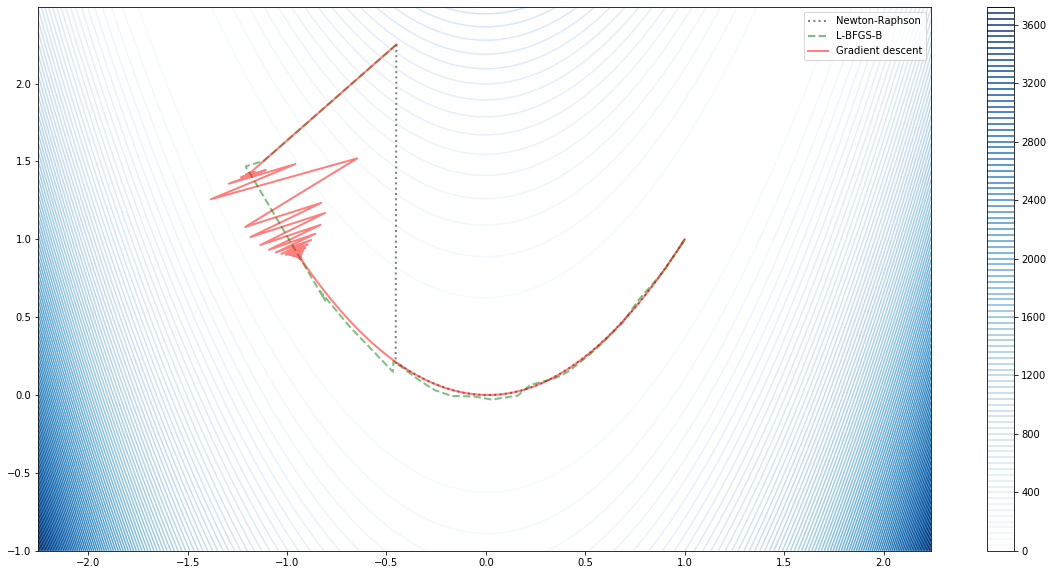

In [135]:
plt.subplots(figsize=(20, 10))

plt.plot([t[0][0] for t in Xhist_newton], [t[0][1] for t in Xhist_newton], ':', color='k', alpha=0.5, linewidth=2, label='Newton-Raphson')
plt.plot([t[0][0] for t in Xhist_bfgs], [t[0][1] for t in Xhist_bfgs], '--', color='g', alpha=0.5, linewidth=2, label='L-BFGS-B')
plt.plot([t[0][0] for t in Xhist], [t[0][1] for t in Xhist], color='r', alpha=0.5, linewidth=2, label='Gradient descent')
plt.contour(X, Y, Z, 100, cmap='Blues')
plt.colorbar()
plt.legend()

plt.show()

In [ ]:
def encode_params(P):
    """
    Flatten and concatenate parameters into a single list.
    """
    flat = np.hstack([p.ravel() for p in P])
    shapes = [p.shape for p in P]
    return flat, shapes

def decode_params(P, shapes):
    """
    Decompress a single list of parameters into individual arrays
    """
    ret = []
    i = 0
    for s in shapes:
        e = i + np.prod(s)
        ret.append(P[i:e].reshape(s))
        i = e
    return ret

#  SoftMax regression

In [100]:
def SoftMax_regression_implementation(Theta_flat, X, Y=None, return_probabilities=False):
    """
    Compute the outputs of a SoftMax classifier, i.e. a loss and gradient.
    
    Parameters
    ----------
    theta_flat : flat array of parameters containing (n_features*n_classes) entries
    
    X : array of features, shape (n_features, n_saples)
    
    Y : optional array of desired targets of shape 1 x n_samples
    
    return_probabilities : logical
        if True, the probabilities are returned and Y is not used
        if False, the los and gradient is computed on the X,Y pairs
        
    Returns
    ----------    
    if return_probabilities == True :
    H : probablities as array of shape num_classes x num_samples
    
    if return_probabilities == False :
    L : loss function value
    
    dLdTheta : gradient of loss function as  (n_features*n_classes) 1-D array
    """
    # X is num_features x num_samples
    num_features, num_samples = X.shape

    # We first reshape Theta_flat into Theta
    Theta = Theta_flat.reshape(num_features, -1)

    # Activation of softmax neurons
    # A's shape is num_classes x num_samples
    A = np.dot(Theta.T, X)
    
    # SoftMax function
    # H is a num_classes x num_samples matrix of probabilities assigned by our model
    # Stability optimization - for each value subtract the maximum activation (https://stackoverflow.com/questions/42599498/numercially-stable-softmax)
    H = A - A.max(0, keepdims=True)
    H = np.exp(H)
    H = H / np.sum(H, axis=0)
    
    if return_probabilities:
        return H

    # The loss is the average per-sample NLL (negative log likelihood)
    # The NLL is the sum of the logarithms of probabilities assigned to each class
    correct_class_likelihoods = np.log(H[Y.ravel(), np.arange(num_samples)])
    L = - 1.0 / num_samples * np.sum(correct_class_likelihoods)

    # For the softmax activation and cross-entropy loss, the derivative dNLL/dA has a simple form
    dLdA = H
    dLdA[Y.ravel(), np.arange(num_samples)] -= 1
    dLdA /= num_samples

    # Now we compute the gradient of the loss with respect to Theta
    dLdTheta = np.dot(X, dLdA.T)

    return L, dLdTheta.reshape(Theta_flat.shape)

Let's test it on iris dataset.

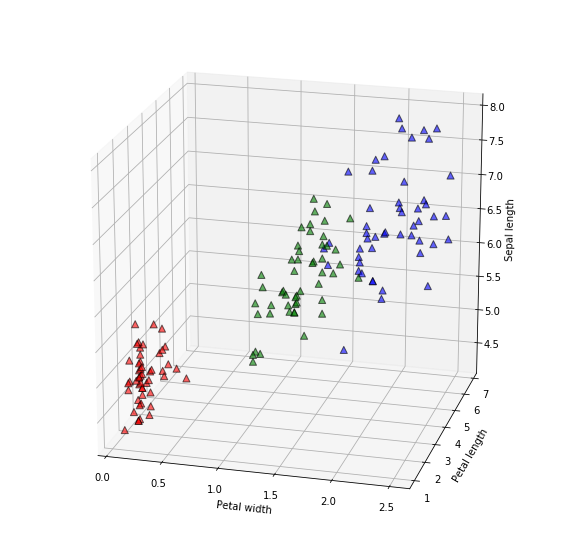

In [101]:
from mpl_toolkits.mplot3d import Axes3D 

iris = datasets.load_iris()
petal_length = iris.data[:, iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]
sepal_length = iris.data[:, iris.feature_names.index('sepal length (cm)')]

iris_x = np.vstack([np.ones_like(petal_length), petal_length, petal_width])
iris_y = iris.target.reshape(1, -1).astype(np.int64)
iris_y_flatten = iris_y.ravel()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(petal_width[iris_y_flatten==0], petal_length[iris_y_flatten==0], sepal_length[iris_y_flatten==0], s=50, alpha=0.6, edgecolors='black',  color='r', marker='^')
ax.scatter(petal_width[iris_y_flatten==1], petal_length[iris_y_flatten==1], sepal_length[iris_y_flatten==1], s=50, alpha=0.6, edgecolors='black',  color='g', marker='^')
ax.scatter(petal_width[iris_y_flatten==2], petal_length[iris_y_flatten==2], sepal_length[iris_y_flatten==2], s=50, alpha=0.6, edgecolors='black',  color='b', marker='^')

ax.set_xlabel('Petal width')
ax.set_ylabel('Petal length')
ax.set_zlabel('Sepal length')

ax.view_init(20, -75)

plt.show()

Training accurracy: 96.000%


[]

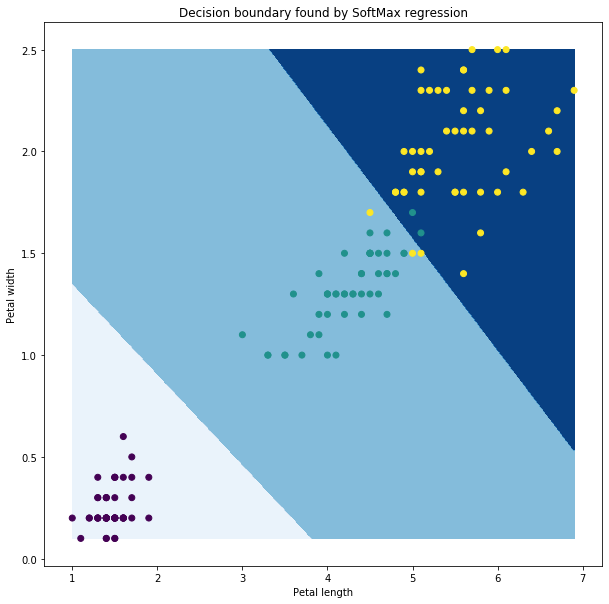

In [148]:
def iris_log_reg_cost(theta): 
    return SoftMax_regression_implementation(theta, iris_x, iris_y, False)

theta_opt = sopt.fmin_l_bfgs_b(iris_log_reg_cost, np.zeros((3 * 3,)), iprint=1)[0]

probabilities = SoftMax_regression_implementation(theta_opt, iris_x, return_probabilities=True)
predictions = np.argmax(probabilities, 0)

print ("Training accurracy: %.3f%%" % ((predictions == iris_y.ravel()).mean() * 100))

petal_lengths, petal_widths = np.meshgrid(
    np.linspace(iris_x[1, :].min(), iris_x[1, :].max(), 500),
    np.linspace(iris_x[2, :].min(), iris_x[2, :].max(), 500))

iris_x_grid = np.vstack([np.ones(np.prod(petal_lengths.shape)),
                         petal_lengths.ravel(), 
                         petal_widths.ravel()])

predictions_grid = SoftMax_regression_implementation(theta_opt, iris_x_grid, return_probabilities=True).argmax(0)

fig = plt.figure(figsize=(10, 10))

plt.contourf(petal_lengths, petal_widths, predictions_grid.reshape(petal_lengths.shape), cmap='Blues')
plt.scatter(iris_x[1,:], iris_x[2,:], c=iris_y.ravel())

plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.title('Decision boundary found by SoftMax regression')

plt.plot()

# Two layer neaural network

In [ ]:
def TwoLayerNet_implementation(Theta_flat, Theta_shapes, X, Y=None, return_probabilities=False):
    """
    Compute the outputs of a SoftMax classifier, or the loss and gradient
    
    Parameters
    ----------
    ThetaFlat : flat array of parameters
    
    ThetaShapes : list of shapes of weight and bias matrices
    
    X : array of features, shape n_features x n_smaples
    
    Y : optional array of desired targets of shape 1 x n_samples
    
    return_probabilities : 
        if True, the probabilities are returned and Y is not used
        if False, the los and gradient is computed on the X,Y pairs
    """
    #X is num_features x num_samples
    num_features, num_samples = X.shape

    #Extract weight matrices
    W1, W2 = decode_params(Theta_flat, Theta_shapes)
    
    X_padded = np.vstack([np.ones((1, num_samples)), X])
    
    # Activation in first layer Shape is num_hidden x num_samples
    #
    # TODO
    # A1 = 
    #

    #Apply the transfer function
    #
    # TODO
    # H1 = 
    #
        
    #Pad with ones
    H1_padded = np.vstack([np.ones((1, num_samples)), H1])
    
    #Now apply the second linear transform
    #
    # TODO
    # A2 = 
    #
    
    #Now compute the SoftMax function
    #O will be a num_classes x num_samples matrix of probabilities assigned by our model  
    #Stability optimization - for each subtract the maximum activation
    O = A2 - A2.max(0, keepdims=True)
    # 
    # TODO - compute SoftMax as vector O. Take the exp and normalize, so all values of O
    #        would sum to 1.0.
    # 

    if return_probabilities:
        return O
    
    #The loss is the average per-sample nll (neg log likelihood)
    #The nll is the sum of the logarithms of probabilities assigned to each class
    correct_class_likelihoods = np.log(O[Y.ravel(), np.arange(num_samples)])
    L = - 1.0/num_samples * np.sum(correct_class_likelihoods)

    #For the softmax activation and cross-entropy loss, the derivative dNLL/dA has a simple form
    #Please fill in its computation
    #
    # TODO
    # dLdA2 = 
    #

    dLdH1_padded = W2.dot(dLdA2)
    dLdH1 = dLdH1_padded[1:,:] #ship the derivatives backpropagated to the added ones
    
    #
    # TODO - compute the derivatives dLdW2 and dLdW1
    # Hint - to compute dLdW1, start with dLdA1
    #
    
    dLdTheta_flat, unused_shapes = encode_params([dLdW1, dLdW2])
    
    #reshape gard into the shape of Theta, for fmin_l_bfsgb to work
    return L, dLdTheta_flat